<a href="https://colab.research.google.com/github/davidabelin/capstone_project_udacity_mle/blob/main/digits_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten Arithmetic

In [ ]:
#@title IMPORTS
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as Image
#import seaborn as sbn

import zipfile
import math
import random as rd
import numpy as np
import pandas as pd
#import os, signal
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input
from tensorflow.keras.optimizers import RMSprop, Adam

In [ ]:
#@title VARIABLES
#Load raw MNIST data as numpy arrays
mnist = tf.keras.datasets.mnist
traintuple, testuple = mnist.load_data()
 
N_val = 1000
N_test = 1000
N_train = 10000
image_size = (28,56) # shape of target image
epochs = 4
batch_size = 100 #1000
learning_rate = 0.005
 
model_kinds = ["miniNN", "CNN", "DNN", "comboNN", "ocNN"]
noise_levels = ["no", "low", "high", "var"]
noise2condition = {nc:d for (nc,d) in zip(noise_levels,
                                           ["No noise", "Low noise", 
                                            "High noise", "Variable noise"])} 
training_keys = []
for nc in noise_levels:
    for k in model_kinds:
        training_keys.append((k,nc))
 
# Same Input layer for all models
input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))

11493376/11490434 [==============================] - 0s 0us/step


# Construct the Input Data

In [ ]:
#@title Define Functions
def scale_array(arr):
    '''Scale an array of numbers.
        Params: numpy array of values to be scaled
        Returns: the same array with values scaled to (0,1)
    '''
    max = np.max(arr)
    min = np.min(arr)
    scaled = (arr - min)/(max - min)
    return scaled
print("Loaded function scale_array(arr)")

def get_noise(image, noise_condition="var"):
    ''' Add a normal disitribution of noise to an image
        Params: image: numpy array with values (0,1)
                noise_factor: one of "no", "low", "high", "var"
        Returns: noisy image array re-normalized to (0,1)
    '''
    cond2num = {"no":0, 
                "low":0.3, 
                "high":1.3, 
                "var":rd.random()}
    noise_factor = np.std(image)*cond2num[noise_condition]
    noise = np.random.normal(np.mean(image), 
                             noise_factor, 
                             size=image.shape)
    ## TODO: Unfortunately have to call scale_array() for second time
    # Renormalize combined image to (0,1)
    return scale_array(noise + image)
print("Loaded function get_noise(image, noise_condition)")

def doubleDigits(datatuple, nc="no"):
    ''' Merge two single-digit images into one double-digit image.
        Params: images: np.array with shape (N,28,28), values 0 to 255
                answers: np.array with shape (N,), values 0 to 9
                nf: "noise factor" (float) is multiples/fractions of image std
        Returns: noisy double-digit image as a numpy array with shape (28,56),
                with values normed to (0.0, 1.0); 
                and the corresponding label, with values now 0 to 99
    '''
    (images,answers)=datatuple  # or x, y
    
    # Randomly select left and right single digit images
    # with values 0 to 9, from the same raw data training
    # set of 60000 images
    left_index = rd.randrange(0, len(answers))   
    right_index = rd.randrange(0, len(answers))
    # Calculate double digit label 0 to 99
    answer = answers[left_index]*10 + answers[right_index]
    
    # Have to scale them here because they have
    # different distributions of pixel values
    left_scaled = scale_array(images[left_index])
    right_scaled = scale_array(images[right_index])

    # Make background array with shape (28,56)
    image = np.zeros(image_size)
    # Group digits closer to middle of new image
    width = image_size[1]
    half_width = width//2  
    # Shift left digit to the right
    image[:,8:half_width+4] += left_scaled[:,4:half_width]
    # Shift right digit to the left
    image[:,half_width-4:width-8] += right_scaled[:,0:half_width-4]

    # Add noise to the new double digit image
    ### TODO: Which will scale it again for second time to [0,1] ###
    # Call get_noise() to overlay a Normal distribution
    # of random pixel values centered on the mean of pixel values
    # in the image and with "noise_factor" as the width of the
    # distribution, from 0 (no distortion) to +inf (uniform distribution),
    # in multiples or fractions of the standard deviation of the
    # pixel values in image, and rescale pixel values to (0,1)
    image = get_noise(image, nc)  
    return image, int(answer)              
print("Loaded function doubleDigits(datatuple, nc=no)")

def getDoubleDigits(datatuple, how_many=1, nc="no"):
    ''' Aggregate a given number of two-digit images, with or without noise
        Params: image array of size (N, (image size)),
                answers array of size (N,)
        Returns: a single 28x56 double-digit image and
                 the corresponding array of int labels
    '''
    yy = np.zeros((how_many,),dtype=int)
    xx = np.zeros((how_many, image_size[0], image_size[1]))
    for i in range(how_many):
        dd, ans = doubleDigits(datatuple, nc)
        yy[i] = ans
        xx[i] = dd
    return (xx, yy)
print("Loaded function getDoubleDigits(datatuple,how_many=1,nc=no)")

def plotLearningCurves(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
print("Loaded function plotLearningCurves(history)")

def guessing(model,n=1,return_image=False):
    answers, guesses, pA, pG = [],[],[],[]
    for count in range(n):
        rindex = rd.randrange(y_test.shape[0])
        ans = y_test[rindex]
        img = x_test[rindex]
        img = img.reshape((1,) + img.shape)    # eg. 1x50x50x1
        guess_set = model.predict(img).flatten()
        guess = np.argmax(guess_set)
        answers += [ans]
        guesses += [guess]
        pG += [guess_set[guess]]
        pA += [guess_set[ans]]

        print("Answer",ans,"\tGuess",guess, "\tp(A)",round(pA[count],2),"\tp(G)",round(pG[count],2))
        if count%10 == 0:
            print ('Processing...',count,"...")
            clear_output(wait=True)

    if return_image:
        return answers, guesses, pA, pG, img
    else:
        return answers, guesses, pA, pG
print("Loaded function guessing(model,n=1,return_image=False)")

def get_guesses(m,n=1):
    results = pd.DataFrame(columns=['Answer','Guess','P(A)','P(G)'])
    results['Answer'],
    results['Guess'],
    results['P(A)'],
    results['P(G)'] = guessing(n, m) 
    return results
print("Loaded function get_guesses(m,n=1)")

def show_layers(model, output_model):
    # Take random image from the training set.
    rindex = rd.randrange(y_test.shape[0])
    ans = y_test[rindex]
    img = x_test[rindex]
    img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
    gue = model.predict(img)
    print("Answer:",ans, "\tGuess:",np.argmax(gue))
    plt.figure(figsize=(3,3))
    plt.imshow(img[0,:,:,0], cmap="binary_r")                 # np shape (28, 28)

    layer_output_maps = output_model.predict( img )
    layer_names = [layer.name for layer in model.layers[1:]]
    for layer_name, layer_map in zip(layer_names, layer_output_maps):
        if len(layer_map.shape) == 4:# and not 'max_pooling' in layer_name:
            n_maps = layer_map.shape[-1]  # number of maps
            if n_maps > 10:
                n_maps = 10
            # Map has shape (1, rows, columns, n_features)
            rows = layer_map.shape[1]
            cols = layer_map.shape[2]
            image_grid = np.zeros((rows, cols * n_maps))
            
            for i in range(n_maps):
                x = layer_map[0, :, :, i]
                x *= 255.0
                image_grid[:, i * cols : (i + 1) * cols] = x
                image_grid[:,i*cols] = 255.
                image_grid[:,i*cols+1] = 0.
                
            scale = 2.           
            plt.figure(figsize=(scale * n_maps, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(image_grid, cmap='gray')
print("Loaded function show_layers(model, output_model)")

Loaded function scale_array(arr)
Loaded function get_noise(image, noise_condition)
Loaded function doubleDigits(datatuple, nc=no)
Loaded function getDoubleDigits(datatuple,how_many=1,nc=no)
Loaded function plotLearningCurves(history)
Loaded function guessing(model,n=1,return_image=False)
Loaded function get_guesses(m,n=1)
Loaded function show_layers(model, output_model)


Answer: 88


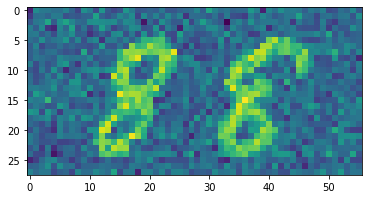

In [ ]:
x, y = getDoubleDigits(traintuple, nc="var")

print('Answer:',y[0]) 
plt.imshow(x[0])#, cmap='gray')

In [ ]:
train_data = {} # {noise:train data}
val_data = {}   # {noise:val data}
test_data = {}  # {noise:test data}
N_train = 100000
N_val = 10000
N_test = 10000
######### GENERATE DD TRAINING DATA FOR ALL NOISE CONDITIONS ###########
for nc in noise_levels:
    ####### Will make a set of train, val, and test images for each noise level
    print ("Noise level:", noise2condition[nc])
    x_train, y_train = getDoubleDigits(traintuple, N_train, nc=nc)
    print("Made",N_train,"new double-digit images to train on.")
    x_val, y_val = getDoubleDigits(testuple, N_val, nc=nc)
    print("Made",N_val,"new double-digit images to validate on.")
    x_test, y_test = getDoubleDigits(testuple, N_test, nc=nc)
    print("Made",N_test,"new double-digit images to test on.")

    ############## Add a channels dimension
    x_train = x_train[..., np.newaxis].astype("float32")
    x_val = x_val[..., np.newaxis].astype("float32")
    x_test = x_test[..., np.newaxis].astype("float32")

    train_data.update({nc:(x_train, y_train)})
    val_data.update({nc:(x_val, y_val)}) 
    test_data.update({nc:(x_test, y_test)})
    

Noise level: No noise


# Build models

## The models

###Baseline model

In [ ]:
###################### baseline model "miniNN"
def buildminiNN(noise=""):
    x = layers.Flatten()(input_layer)
    output_layer = layers.Dense(100, activation='softmax')(x)

    miniNN = Model(input_layer, output_layer, name="miniNN_"+noise)
#miniNN.summary()

###CNN

In [ ]:
###################### Build CNN
def buildCNN(noise=""):
    x = layers.Conv2D(20, 2, padding='same', activation='relu')(input_layer)
    x = layers.AveragePooling2D(2)(x)
    x = layers.Conv2D(30, 3, activation='relu')(x) 
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    output_layer = layers.Dense(100, activation='softmax')(x)

    CNN = Model(input_layer, output_layer, name="CNN_"+noise)

    ####################### Layer-outputs model for visualization
    layer_outputs = [layer.output for layer in CNN.layers[1:]]
    CNN_outputs = Model(input_layer, layer_outputs)

    #CNN.summary()

### Dense NN

In [ ]:
################### Build DNN
x = layers.Flatten()(input_layer)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(500, activation='relu')(x) 
x = layers.Dropout(0.1)(x)
output_layer = layers.Dense(100, activation='softmax')(x)
DNN = Model(input_layer, output_layer, name="DNN")
DNN.summary()

### Mixed model

In [ ]:
##################### Hybrid CNN/DNN: comboNN
x = input_layer #same as the others
x = layers.Conv2D(20, 3, activation='relu')(input_layer)
x = layers.AveragePooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(200, activation='relu')(x)
x = layers.Dropout(0.2)(x)
output_layer = layers.Dense(100, activation='softmax')(x)
comboNN = Model(input_layer, output_layer, name="comboNN")

comboNN.summary()

###Overcomplicated Model

In [ ]:
###### OVERCOMPLICATED MODEL ocNN ########### 
#input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))

x = layers.Flatten()(input_layer)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x1 = layers.Dense(600, activation='relu')(x) 
x1 = layers.Dropout(0.3)(x1)

x2 = layers.Dense(200, activation='relu')(x) 
x2 = layers.Dropout(0.1)(x2)

y = layers.Conv2D(20, 2, padding='same', activation='relu')(input_layer)
y = layers.MaxPooling2D(2)(y)

y1 = layers.Conv2D(20, 3, activation='relu')(y) 
y1 = layers.AveragePooling2D(2)(y1)
y1 = layers.Flatten()(y1)
y1 = layers.Dropout(0.2)(y1)

y2 = layers.Conv2D(20, 2, activation='relu')(y) 
y2 = layers.Conv2D(20, 2, activation='relu')(y2)
y2 = layers.MaxPooling2D(2)(y2)
y2 = layers.Flatten()(y2)
y2 = layers.Dropout(0.1)(y2)

z1 = layers.Concatenate()([x1,y1])
z1 = layers.Dropout(0.3)(z1)

z2 = layers.Concatenate()([x2,y2])
z2 = layers.Dropout(0.1)(z2)

z = layers.Concatenate()([z1,z2])
z = layers.Dense(1000,activation="relu")(z)
z = layers.Dropout(0.3)(z)

logits_layer = layers.Dense(100, activation='softmax')(z) 
ocNN = Model(input_layer, logits_layer, name="ocNN")

####################### Summary / Plot
ocNN.summary()
#tf.keras.utils.plot_model(ocNN,show_shapes=True)

In [ ]:
tf.keras.utils.plot_model(ocNN,show_shapes=True)

## Train, compile, and evaluate all models

In [ ]:
#########################
#@title BUILD a MODEL for each NOISE CONDITION

def buildModel(key):
    (model_kind, noise) = key
    input_layer = layers.Input(shape=(image_size[0], image_size[1], 1))
    
    if "miniNN" in model_kind:
        ###################### baseline model "miniNN"
        x = layers.Flatten()(input_layer)
        output_layer = layers.Dense(100, activation='softmax')(x)
        miniNN = Model(input_layer, output_layer, name="miniNN_"+noise)
        print ("built", miniNN.name)
        return miniNN

    elif "CNN" in model_kind:
        ###################### Build CNN
        x = layers.Conv2D(20, 2, padding='same', activation='relu')(input_layer)
        x = layers.AveragePooling2D(2)(x)
        x = layers.Conv2D(30, 3, activation='relu')(x) 
        x = layers.MaxPooling2D(2)(x)
        x = layers.Flatten()(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        CNN = Model(input_layer, output_layer, name="CNN_"+noise)
        print ("built", CNN.name)
        return CNN
    
    elif "DNN" in model_kind:
        ################### Build DNN
        x = layers.Flatten()(input_layer)
        x = layers.Dense(1000, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Dense(500, activation='relu')(x) 
        x = layers.Dropout(0.1)(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        DNN = Model(input_layer, output_layer, name="DNN_"+noise)
        print ("built", DNN.name)
        return DNN

    elif "comboNN" in model_kind:
        ##################### Hybrid CNN/DNN: comboNN
        x = input_layer #same as the others
        x = layers.Conv2D(20, 3, activation='relu')(input_layer)
        x = layers.AveragePooling2D(2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(200, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        output_layer = layers.Dense(100, activation='softmax')(x)
        comboNN = Model(input_layer, output_layer, name="comboNN_"+noise)
        print ("built", comboNN.name)
        return comboNN

    elif "ocNN" in model_kind:
        ###### OVERCOMPLICATED MODEL ocNN ########### 
        x = layers.Flatten()(input_layer)
        x = layers.Dense(1000, activation='relu')(x)
        x = layers.Dropout(0.2)(x)

        x1 = layers.Dense(600, activation='relu')(x) 
        x1 = layers.Dropout(0.3)(x1)

        x2 = layers.Dense(200, activation='relu')(x) 
        x2 = layers.Dropout(0.1)(x2)

        y = layers.Conv2D(20, 2, padding='same', activation='relu')(input_layer)
        y = layers.MaxPooling2D(2)(y)

        y1 = layers.Conv2D(20, 3, activation='relu')(y) 
        y1 = layers.AveragePooling2D(2)(y1)
        y1 = layers.Flatten()(y1)
        y1 = layers.Dropout(0.2)(y1)

        y2 = layers.Conv2D(20, 2, activation='relu')(y) 
        y2 = layers.Conv2D(20, 2, activation='relu')(y2)
        y2 = layers.MaxPooling2D(2)(y2)
        y2 = layers.Flatten()(y2)
        y2 = layers.Dropout(0.1)(y2)

        z1 = layers.Concatenate()([x1,y1])
        z1 = layers.Dropout(0.3)(z1)

        z2 = layers.Concatenate()([x2,y2])
        z2 = layers.Dropout(0.1)(z2)

        z = layers.Concatenate()([z1,z2])
        z = layers.Dense(1000,activation="relu")(z)
        z = layers.Dropout(0.3)(z)

        logits_layer = layers.Dense(100, activation='softmax')(z) 
        ocNN = Model(input_layer, logits_layer, name="ocNN_"+noise)
        print ("built", ocNN.name)
        return ocNN
    
    else:
        print ("Could not find that kind of model.")
        return None

In [ ]:
#@title Compile and Train function
## Same training loop for all models, with same compiler too
def train(model, traintuple, valtuple, epochs=4):
    '''Train a model on the given sets of data
        Params: the given model,
                the train data as a tuple of x,y,
                the test data as a tuple of x,y
        Returns: a dictionary of metric values after each epoch of training
    '''
    (x_train, y_train) = traintuple
    (x_val, y_val) = valtuple

    history = model.fit(x=x_train,
                        y=y_train,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val),
                        #validation_split=0.01,
                        epochs=epochs,  
                        verbose=1)   
    return history.history
print("loaded function train(model, traintuple, testuple, epochs=4)")

def compile_model(model):    
    model.compile(  loss="sparse_categorical_crossentropy",
                    optimizer=Adam(lr=learning_rate),
                    metrics=['acc'])
    print ("Compiled model", model.name)
print("loaded function compile_model(model)")

In [ ]:
#################### Build all 20 models and store in dict getModel
getModel = {}
for key in training_keys: 
     model = buildModel(key)
     getModel.update({key:model})
list(getModel.keys())

In [ ]:
####################### Compile and Train all 20 models
stats = {}
for key in training_keys:    
    nc = key[1]
    model = getModel[key]
    compile_model(model)
    train_stats = train(model, train_data[nc], val_data[nc], epochs=epochs)
    stats.update({key:train_stats})

In [ ]:
plotLearningCurves(stats[rd.choice(training_keys)])

##Evaluation and Results

In [ ]:
############################# Evaluation: ALL MODELS, ALL NOISE LEVELS
results = {}
evalkeys = []
for key in training_keys:
    model = getModel[key]
    print (">>>>>>>>>>>>>>> Key:", key)
    for nl in noise_levels:
        evalkey = (model.name, nl)
        evalkeys += [evalkey]
        x, y = test_data[nl]
        evaluated = model.evaluate( x=x, y=y, verbose=0, batch_size=50) #500
        results.update({evalkey:round(evaluated[1], 4)})
        condition = noise2condition[nl]
        print(model.name,"accuracy on",condition,":",round(evaluated[1], 4))

In [ ]:
#models = model_kinds  #list(set(t[0] for t in training_keys))
rows = len(training_keys)
results_df = pd.DataFrame(columns=["model"]+["trained_on"]+noise_levels, index=range(rows))
for row, (model_kind, train_condition) in enumerate():
    results_df.iloc[row]["model"]=model_kind
    results_df.iloc[row]["trained_on"]=noise2condition[train_condition]
    for test_condition in noise_levels:                 #TO DO:
        results_df.iloc[row][test_condition] = results[(model_kind+"_"+train_condition, test_condition)]
results_df = results_df.sort_values("model")

In [ ]:
rows = len(evalkeys)
results_df = pd.DataFrame(columns=["model"]+noise_levels, index=range(rows))
for row, key in enumerate(evalkeys):
    key = (trained_model, eval_cond)
    results_df.iloc[row]["model"]=model_kind
    for en in noise_levels:            
        results_df.iloc[row][eval_cond] = results[key]
#results_df = results_df.sort_values("model")

In [ ]:
results[evalkeys[0]]

0.7926

In [ ]:
plt.plot(data=results)

<Figure size 432x864 with 0 Axes>

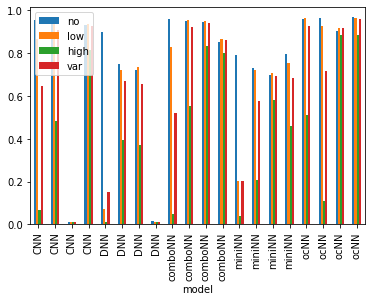

In [ ]:
results_df.plot("model", ["no","low","high","var"], kind='bar')

_______________________

## Misc

In [ ]:
for h in var_noise_stats.values():
    plotLearningCurves(h)

In [ ]:
answers, guesses, pA, pG, img = guessing(model=miniNN,n=1, return_image=True)
print (answers[0], guesses[0])
print (pA[0], pG[0])
plt.imshow(img[0,:,:,0])

In [ ]:
plotLearningCurves(combo_metrics)

In [ ]:
layer_outputs = [layer.output for layer in comboNN.layers[1:]]
combo_outputs = Model(input_layer, layer_outputs)
show_layers(comboNN, combo_outputs)

In [ ]:
results = get_results(100,mixedNN)
tv = results['Guess'] == results['Answer']
wrongs = results.loc[~tv]
wrongs.sort_values('Answer')

In [ ]:
show_layers(CNN, CNN_outputs)

In [ ]:
predicts = [np.argmax(p) for p in CNN.predict(x_train)]
rid = rd.randrange(len(y_train))
print ("Guess:",predicts[rid], "Ans:",y_train[rid])
plt.imshow(x_train[rid].reshape((28,56)), cmap="gray")

#### Unnecessary approaches to the data incl. visualization

In [ ]:
####################### Layer-outputs model
#layer_outputsX = [layer.output for layer in modelX.layers[1:]]
#output_modelX = Model(input_layer, layer_outputsX)
modelX_neurons = ocNN.variables[0].numpy().T
modelX_neurons_df = pd.DataFrame(modelX_neurons)
neuronX_df = pd.DataFrame(modelX_neurons[2].reshape((28,56)))
#neuronX_df  

nxmin = min(neuronX_df.min())
nxmax = max(neuronX_df.max())
nxmean = np.mean(neuronX_df.mean())
nxstd = np.mean(neuronX_df.std())
print (nxmin,nxmax,nxmean,nxstd)
print ("nxmin*255, nxmax*255", nxmin*255, nxmax*255)

#neuronX_df *= 255.
neuronX_df += nxstd
neuronX_df.clip(0,nxmax)
#neuronX_df *= 255

plt.imshow(neuronX_df)          

In [ ]:
variables = ocNN.variables[0].numpy()
num_nodes = variables.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
for coef, ax in zip(variables.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    coef = coef
    ax.matshow(coef.reshape(image_size), cmap=plt.cm.viridis)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [ ]:
minimal_results = get_results(100, miniNN)
resultsCNN = get_results(100, CNN)
resultsOC = get_results(100, ocNN)
#resultsX

In [ ]:
plt.scatter(minimal_results['Guess'],minimal_results['Answer'])
plt.scatter(resultsCNN['Guess'],resultsCNN['Answer'])
plt.scatter(resultsOC['Guess'],resultsOC['Answer'])

In [ ]:
tvX = resultsX['Guess'] == resultsX['Answer']
wrongsX = resultsX.loc[~tvX]
wrongsX.sort_values('Answer')

In [ ]:
# "one shot iterator"
answers, guesses, pA, pG, img = guessing(modelX,n=1, return_image=True)
print ("Label:", answers[0], "\tPredict:", guesses[0])
print ("pLabel =",pA[0], "\tpPredict = ", pG[0])
plt.imshow(img[0,:,:,0],cmap="gray")

In [ ]:
def showWeights():
    weights0 = modelX.weights[0].numpy()
    num_nodes = weights0.shape[1]
    num_rows = int(math.ceil(num_nodes / 10.0))
    fig, axes = plt.subplots(num_rows, 10, figsize=(40, 2 * num_rows))
    for coef, ax in zip(weights0.T, axes.ravel()):
        # Weights in coef is reshaped from 1x784 to 28x28.
        ax.matshow(coef.reshape(image_size), cmap=plt.cm.bone)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.show()

showWeights()

In [ ]:
no_noise_miniNN = train(miniNN)

In [ ]:
CNN.compile(  loss="sparse_categorical_crossentropy",
                optimizer=Adam(lr=learning_rate),
                metrics=['acc'])

history = CNN.fit( x=x_var_noise_train.reshape(...,1),
                    y=y_var_noise_train,
                    batch_size=batch_size,
                    validation_data=(x_var_noise_test, y_var_noise_test),
                    #validation_split=0.1,
                    epochs=epochs,  
                    verbose=1)

CNN.evaluate(x_no_noise_test, y_no_noise_test)

In [ ]:
CNN.evaluate(x_low_noise_test, y_low_noise_test)

In [ ]:
x_var_noise_train .reshape(x_var_noise_train.shape + (1))

In [ ]:
xsh = x_var_noise_train.shape
clear = clear_output
print ("text")
gDD = getDoubleDigits

In [ ]:

epochs = 3
batch_size = 500
learning_rate = 0.005

############################# Recompile and Train models under each condition

############################# !
### s_by_c{cond:{stats}} >> stats{modelname:history} >> history{metric:list}
############################# 

get_stats = {}  # {key:train history}
#get_model = 
#weights_by_condition = {}
for nc in noise: 
    print ("\nNoise level:",nc) 
    stats = {}
    model_weights = {}
    for model in model_list:
        model = rebuildModel(model)
        print (">>>>>>\tTraining:",model.name,"   <<<<<<")
        trainset = train_data[nc]
        testset = test_data[nc]
        history = train(model, trainset, testset, epochs=3)
        model_weights.update({model.name:model.get_weights()})
        stats.update({model.name:history})
    
    weights_by_condition.update({nc:model_weights})
    stats_by_condition.update({nc:stats})

In [ ]:
# Map has shape (1, rows, columns, n_features)
ridx = rd.randrange(0,N_train-5)
condit = "high"
layer_map = train_data[condit][0][ridx:ridx+5] #trainset[0][0:5]
rows = layer_map.shape[1]
cols = layer_map.shape[2]
n_maps = layer_map.shape[0]
image_grid = np.zeros((rows, cols * n_maps))

for i in range(n_maps):
    x = layer_map[i, :, :]
    x *= 255.0
    image_grid[:, i * cols : (i + 1) * cols] = x
    image_grid[:,i*cols] = 255.
    image_grid[:,i*cols+1] = 0.
    
scale = 4           
plt.figure(figsize=(scale * n_maps, scale))
plt.title(train_data[condit][1][ridx:ridx+5])
#plt.grid(False)
plt.imshow(image_grid)#, cmap='gray')

In [ ]:
for mn in model_names: 
    xm = name2model[mn]
    xm = rebuildModel(xm)
    xm.name